   Unnamed: 0  State  Sex  GeneralHealth  PhysicalHealthDays  \
0         342      0    0              0                 4.0   
1         343      0    1              0                 0.0   
2         345      0    1              0                 0.0   
3         346      0    0              1                 5.0   
4         347      0    0              2                 3.0   

   MentalHealthDays  LastCheckupTime  PhysicalActivities  SleepHours  \
0               0.0                0                   1         9.0   
1               0.0                0                   1         6.0   
2               0.0                0                   0         8.0   
3               0.0                0                   1         9.0   
4              15.0                0                   1         5.0   

   RemovedTeeth  ...  HeightInMeters  WeightInKilograms    BMI  \
0             0  ...            1.60              71.67  27.99   
1             0  ...            1.78              

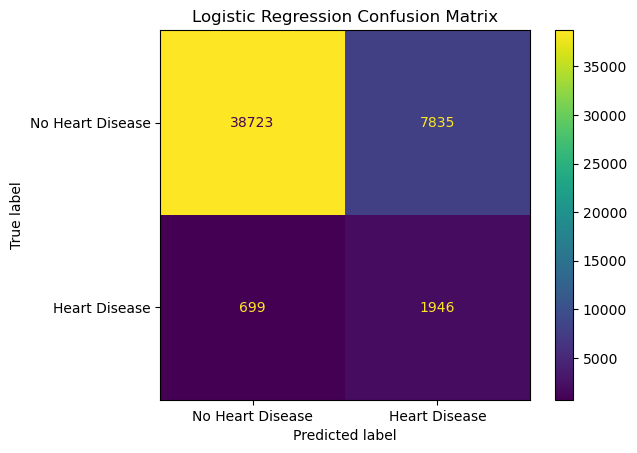

Logistic Regression AUC-ROC: 0.87


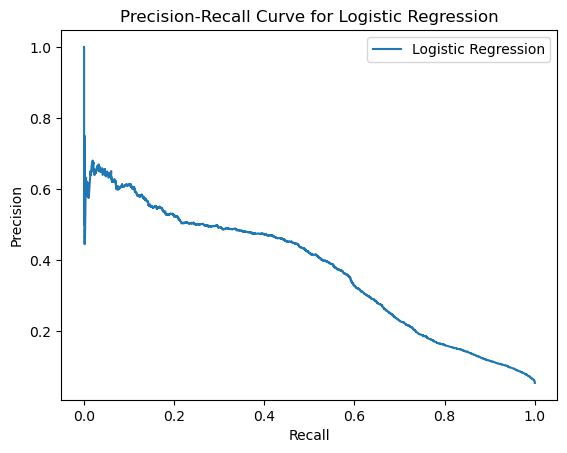

Random Forest Results:
Tuned Random Forest Accuracy: 0.90
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     46558
           1       0.26      0.45      0.33      2645

    accuracy                           0.90     49203
   macro avg       0.61      0.69      0.64     49203
weighted avg       0.93      0.90      0.91     49203



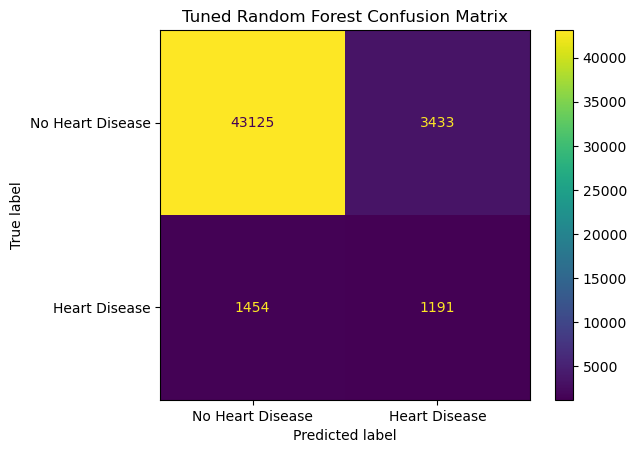

Tuned Random Forest AUC-ROC: 0.78


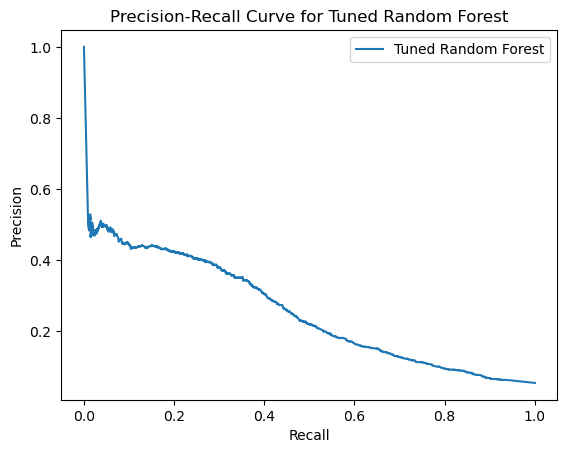

Logistic Regression Accuracy: 0.8266
Tuned Random Forest Accuracy: 0.9007


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 加载数据
data_cleaned = pd.read_csv('data_cleaned.csv')

# 查看数据基本信息
print(data_cleaned.head())
print(data_cleaned.info())

# 计算与目标变量的相关性
correlation_matrix = data_cleaned.corr()
strong_correlation_cols = correlation_matrix['HadHeartAttack'].abs().sort_values(ascending=False)
print("相关性排序:", strong_correlation_cols)

# 筛选强相关特征（相关性 > 0.1）
strong_correlation_cols = strong_correlation_cols[strong_correlation_cols > 0.1].index.tolist()
strong_correlation_cols.remove('HadHeartAttack')
print("强相关特征:", strong_correlation_cols)

# 确保所有列为数值类型
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# 特征和目标变量
X = data_cleaned[strong_correlation_cols]
y = data_cleaned['HadHeartAttack'].astype('int')

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 检查类别分布
print("训练集类别分布:\n", y_train.value_counts())
print("测试集类别分布:\n", y_test.value_counts())

# 使用 SMOTE 平衡数据
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("重采样后类别分布:\n", y_train_resampled.value_counts())

# 模型评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 生成混淆矩阵和分类报告
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=1)

    # 输出结果
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Heart Disease', 'Heart Disease'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # 计算 AUC-ROC
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"{model_name} AUC-ROC: {roc_auc:.2f}")

    return accuracy

# 绘制 PR 曲线
def plot_pr_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.show()

# Logistic Regression 模型
logistic_model = LogisticRegression(random_state=42, max_iter=1000, C=0.1, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression Results:")
logistic_accuracy = evaluate_model(logistic_model, X_test, y_test, "Logistic Regression")
plot_pr_curve(logistic_model, X_test, y_test, "Logistic Regression")

# 随机森林模型调优
# 调整参数网格，减少组合数量
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# 减少交叉验证的次数
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=2)
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = grid_search.best_estimator_
print("Random Forest Results:")
rf_accuracy = evaluate_model(best_rf_model, X_test, y_test, "Tuned Random Forest")
plot_pr_curve(best_rf_model, X_test, y_test, "Tuned Random Forest")

# 输出两个模型的准确率
print(f"Logistic Regression Accuracy: {logistic_accuracy:.4f}")
print(f"Tuned Random Forest Accuracy: {rf_accuracy:.4f}")

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 加载数据
data_cleaned = pd.read_csv('data_cleaned.csv')

# 查看数据基本信息
print(data_cleaned.head())
print(data_cleaned.info())

   Unnamed: 0  State  Sex  GeneralHealth  PhysicalHealthDays  \
0         342      0    0              0                 4.0   
1         343      0    1              0                 0.0   
2         345      0    1              0                 0.0   
3         346      0    0              1                 5.0   
4         347      0    0              2                 3.0   

   MentalHealthDays  LastCheckupTime  PhysicalActivities  SleepHours  \
0               0.0                0                   1         9.0   
1               0.0                0                   1         6.0   
2               0.0                0                   0         8.0   
3               0.0                0                   1         9.0   
4              15.0                0                   1         5.0   

   RemovedTeeth  ...  HeightInMeters  WeightInKilograms    BMI  \
0             0  ...            1.60              71.67  27.99   
1             0  ...            1.78              

In [4]:
corr = data_cleaned.corr()
strong_correlation_cols = [col for col in corr.columns if abs(corr.loc['HadHeartAttack', col]) >= 0.05 and col != 'HadHeartAttack']

# Select features (X) and target (y)
X = data_cleaned[strong_correlation_cols]
y = data_cleaned['HadHeartAttack']

strong_correlation_cols

['Sex',
 'GeneralHealth',
 'PhysicalHealthDays',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadAngina',
 'HadStroke',
 'HadCOPD',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'ChestScan',
 'AgeCategory',
 'AlcoholDrinkers',
 'PneumoVaxEver']

In [6]:
# 确保所有列为数值类型
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# 特征和目标变量
X = data_cleaned[strong_correlation_cols]
y = data_cleaned['HadHeartAttack'].astype('int')

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 输出训练集和测试集的形状
print("训练集特征形状:", X_train.shape)
print("测试集特征形状:", X_test.shape)
print("训练集目标形状:", y_train.shape)
print("测试集目标形状:", y_test.shape)

训练集特征形状: (196810, 22)
测试集特征形状: (49203, 22)
训练集目标形状: (196810,)
测试集目标形状: (49203,)


In [7]:
# 模型评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 生成混淆矩阵和分类报告
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=1)

    # 输出结果
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # 绘制混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Heart Disease', 'Heart Disease'])
    disp.plot()
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

    # 计算 AUC-ROC
    if hasattr(model, "predict_proba"):
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print(f"{model_name} AUC-ROC: {roc_auc:.2f}")

    return accuracy

In [8]:
# 绘制 PR 曲线
def plot_pr_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label=f"{model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend()
    plt.show()

In [9]:
# 使用 SMOTE 平衡数据
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("重采样后类别分布:\n", y_train_resampled.value_counts())

重采样后类别分布:
 0    186020
1    186020
Name: HadHeartAttack, dtype: int64


Logistic Regression Results:
Logistic Regression Accuracy: 0.83
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.83      0.90     46558
           1       0.20      0.76      0.32      2645

    accuracy                           0.83     49203
   macro avg       0.59      0.80      0.61     49203
weighted avg       0.94      0.83      0.87     49203



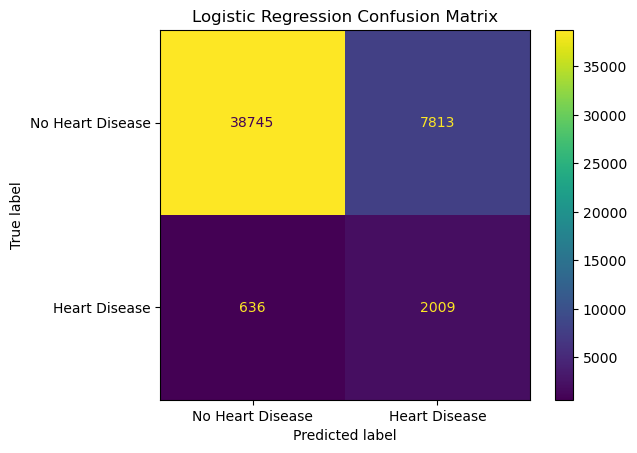

Logistic Regression AUC-ROC: 0.88


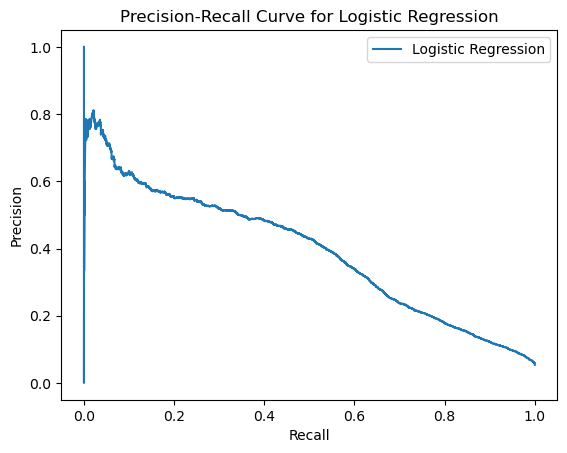

In [10]:
# Logistic Regression 模型
logistic_model = LogisticRegression(random_state=42, max_iter=1000, C=0.1, solver='liblinear', class_weight='balanced')
logistic_model.fit(X_train_resampled, y_train_resampled)
print("Logistic Regression Results:")
logistic_accuracy = evaluate_model(logistic_model, X_test, y_test, "Logistic Regression")
plot_pr_curve(logistic_model, X_test, y_test, "Logistic Regression")

Random Forest Results:
Tuned Random Forest Accuracy: 0.94
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     46558
           1       0.44      0.34      0.38      2645

    accuracy                           0.94     49203
   macro avg       0.70      0.66      0.68     49203
weighted avg       0.94      0.94      0.94     49203



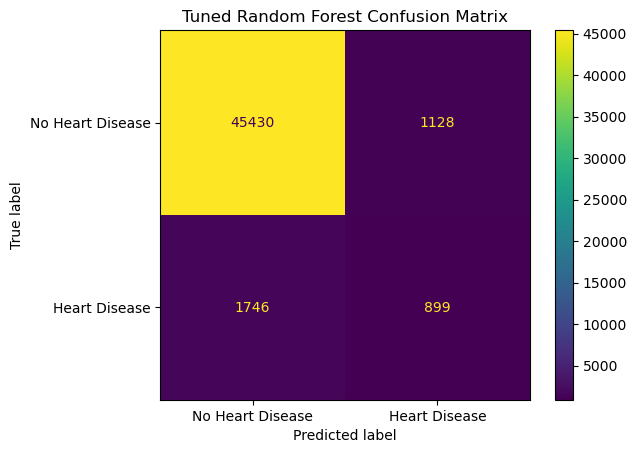

Tuned Random Forest AUC-ROC: 0.85


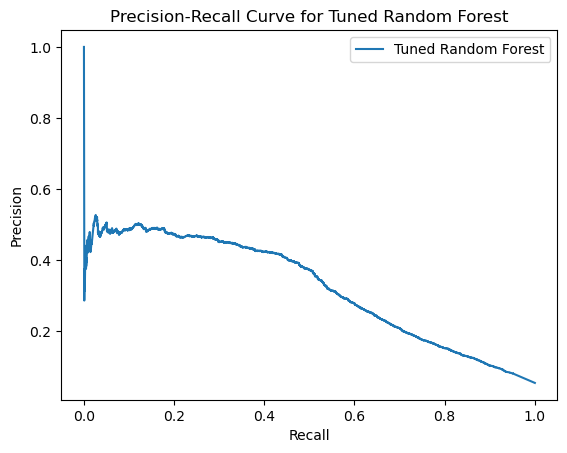

Logistic Regression Accuracy: 0.8283
Tuned Random Forest Accuracy: 0.9416


In [11]:
# 随机森林模型调优
# 调整参数网格，减少组合数量
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# 减少交叉验证的次数
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid, cv=2)
grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = grid_search.best_estimator_
print("Random Forest Results:")
rf_accuracy = evaluate_model(best_rf_model, X_test, y_test, "Tuned Random Forest")
plot_pr_curve(best_rf_model, X_test, y_test, "Tuned Random Forest")

# 输出两个模型的准确率
print(f"Logistic Regression Accuracy: {logistic_accuracy:.4f}")
print(f"Tuned Random Forest Accuracy: {rf_accuracy:.4f}")